In [1]:
import sys
sys.path.append("../../marineHeatWaves/")
sys.path.append("physiology/")

import marineHeatWaves as mh

from tpc import tpc

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

from dask.distributed import Client

import cloudpickle

import gcsfs
import s3fs 
import boto3

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:36423 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 132.82 GB


In [4]:
# EC2 Instance Type
! curl http://169.254.169.254/latest/meta-data/instance-type

m5a.8xlarge

# Phytoplankton Isolates + MHWs. 

Tony Cannistra, Apr 2020

Taking a step back from latitudinally extrapolating thermal reaction norms, we instead move to looking at SST dynamics local to individual phytoplankton isolates to remove some potentially negative effects of the extrapolation . 

In [6]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')
plankton = plankton[
    (plankton.habitat == 'marine') &
    (plankton.curvequal == 'good')
].dropna(subset=['isolation.latitude', 'isolation.longitude'], axis=0)
len(plankton)

89

In [7]:
plankton.head()

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
0,1,"Terra Nova Bay, Ross Sea, Antarctica",-74.83,164.50,marine,Koliella antarctica strain SAG 2030,Koliella antarctica,NaN,NaN,SAG 2030,...,good,good,good,-40.320257,-0.007766,1.0,1.0,1.0,1.0,1.0
2,3,"Windmill Islands, Antarctica",-66.28,110.48,marine,Klebsormidium strain UMACC 227,Klebsormidium,NaN,NaN,UMACC 227,...,good,good,good,277.833630,0.010216,0.0,0.0,0.0,0.0,0.0
3,5,"Arthur Harbor, Palmer Station, Antarctica",-64.78,-64.06,marine,Phaeocystis antarctica strain CCMP 1871,Phaeocystis antarctica,NaN,NaN,CCMP 1871,...,good,good,good,-5.192227,-0.005703,1.0,1.0,1.0,1.0,1.0
8,11,"Southern Ocean, Indian sector",-58.00,62.00,marine,Pseudo-nitzschia turgiduloides,Pseudo-nitzschia turgiduloides,Nitzschia turgiduloides,NaN,NaN,...,good,good,good,-4.634105,-0.004083,1.0,1.0,1.0,1.0,1.0
11,14,"Big Glory Bay, New Zealand",-46.98,168.12,marine,Emiliania huxleyi,Emiliania huxleyi,Coccolithus huxleyi,NaN,NaN,...,good,good,good,-111.068341,-0.013906,1.0,1.0,1.0,1.0,1.0


## Set up MHW detection

This is largely copied from [`../mhw_pipeline/gen_mhw_all.ipynb`](../mhw_pipeline/gen_mhw_all.ipynb). Should put this in a module. 

In [91]:
SAVED_PARAMS = [
    'intensity_max',
    'intensity_cumulative',
    'intensity_var',
    'intensity_mean',
    'rate_onset',
    'rate_decline',
    'index_start', 
    'index_end',
    'index_peak',
    'duration'
]
dim_idx_mapping = {
        **{
            i : SAVED_PARAMS[i]
            for i in range(len(SAVED_PARAMS))
        }, 
        **{
            len(SAVED_PARAMS): 'mhw',
            len(SAVED_PARAMS) + 1 : 'clim_thresh',
            len(SAVED_PARAMS) + 2 : 'clim_seas'
        }
}
def mhw_1d(temps, time):
    SAVED_PARAMS_loc = SAVED_PARAMS.copy()
    if(np.isnan(temps).any()): return np.zeros((len(SAVED_PARAMS_loc) + 3, time.shape[0]))

    ordinals =  np.array([pd.Timestamp(t).toordinal() for t in time])
    dets = mh.detect(ordinals, temps.copy())
    events = dets[0]['n_events']
    del dets[0]['n_events']
    
    arrays = [
        np.zeros_like(time, dtype='float64')
        for _ in range(len(SAVED_PARAMS_loc)) 
    ]
    arrays.append(np.zeros_like(time, dtype='int'))
    
    for event_i in range(events):
        start_date = dets[0]['index_start'][event_i]
        end_date = dets[0]['index_end'][event_i]
        
        # set binary param
        arrays[-1][start_date:end_date] = event_i
        # set all params
        for _i, param in enumerate(SAVED_PARAMS_loc):
#             print(f'saving param {param}')
            param_data = dets[0][param][event_i]
            arrays[_i][start_date:end_date] = param_data
                
        
    clim_thresh = dets[1]['thresh'] 
    clim_seas = dets[1]['seas']
        
    return np.array(
        arrays + [clim_thresh, clim_seas]
    )

def get_nearest_mhw_detections(sst, lat, lon):
    these_sst = sst.sel(lat=lat, lon=lon, method='nearest', tolerance=0.25)
    dets = xr.apply_ufunc(
        mhw_1d, 
        these_sst.sst.chunk({'time': -1}), 
        these_sst.time, 
        input_core_dims = [['time'], ['time']],
        output_core_dims=[["param","time"]],
        output_dtypes=['float64'],
        dask='parallelized', 
        output_sizes={"param": len(SAVED_PARAMS) + 3}, # + 3 for binary MHW detection parameter and climatology
        vectorize=True
    )
    return(dets.to_dataset(dim='param').rename_vars(dim_idx_mapping))

Bring in sea surface temperature measurements: 

In [92]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

Generate MHW detections for each plankton isolate:

In [93]:
isolate_mhws_tasks = {
    x['isolate.code'] : get_nearest_mhw_detections(oisst, x['isolation.latitude'], x['isolation.longitude'])
               for _, x in plankton.iterrows()
}

Execute mhw tasks (~1-2 minutes with 32 cores): 

In [94]:
%%time
isolate_mhws = client.compute(isolate_mhws_tasks, sync=True, optimize_graph=True)

CPU times: user 31 s, sys: 2.33 s, total: 33.4 s
Wall time: 1min 10s


## Compute TPCs for each isolate

Here we use the form of the reaction norm published in Thomas et al. 2012. 

In [95]:
tpcs = {
    s['isolate.code'] : partial(tpc,
            a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist'])
    for _, s in plankton.iterrows()
}

## Compute performance for each isolate

We use the TPCs above to compute performance both during normal SST and for the climatology in the single grid-cell within 0.25 degrees of the isolate location. 

In [96]:
tmax_col = 'tmax'
tmin_col = 'tmin'
topt_col = 'mu.g.opt.list'

In [97]:
performance_tasks = {}
for i, (_, isolate) in tqdm.tqdm(enumerate(plankton.iterrows())):
    
    _tpc = tpcs[isolate['isolate.code']]
    _relevant_sst = oisst.sel(
        lat=isolate['isolation.latitude'], 
        lon=isolate['isolation.longitude'],
        method='nearest', tolerance=0.25
    )
    _tmin = isolate[tmin_col]
    _tmax = isolate[tmax_col]
    _topt = isolate[topt_col]
    values = xr.apply_ufunc(
        _tpc,
        _relevant_sst.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).sst.T
    
    _relevant_mhws = isolate_mhws[isolate['isolate.code']]
    
        
    performance = xr.full_like(_relevant_sst, fill_value=0.).rename_vars({'sst' : "performance"})
    performance['performance_clim'] = xr.zeros_like(performance.performance)
    performance['topt'] = xr.zeros_like(performance.performance)
    performance['tmin'] = xr.zeros_like(performance.performance)
    performance['tmax'] = xr.zeros_like(performance.performance)
    performance.attrs = {}
    
    values_clim = xr.apply_ufunc(
        _tpc,
        _relevant_mhws.clim_seas.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).T
    
    performance['performance'] = values
    
    performance['performance_clim'] = values_clim
    
    performance['topt'] = _topt
    
    performance['tmin'] = _tmin
    
    performance['tmax'] = _tmax
    
    performance_tasks[isolate['isolate.code']] = performance.assign_coords(isolate = isolate['isolate.code'])
    

89it [00:01, 46.04it/s]


Execute computation (~1m, 32 cores)

In [98]:
%%time
isolate_performance = client.compute(performance_tasks, sync=True, optimize_graph=True)

CPU times: user 28.1 s, sys: 2.42 s, total: 30.5 s
Wall time: 55.7 s


## Merge MHWs and Performance for analysis 

We combine into a single xarray Dataset. 

In [99]:
isolate_merged_performance = [xr.merge([isolate_mhws[ic], isolate_performance[ic]]) for ic in plankton['isolate.code']]

In [100]:
isolate_combined = xr.concat(isolate_merged_performance, dim='isolate')

In [101]:
isolate_combined

<xarray.Dataset>
Dimensions:               (isolate: 89, time: 13636)
Coordinates:
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
    lat                   (isolate) float32 -74.875 -66.375 ... -36.125 60.125
    lon                   (isolate) float32 164.625 110.375 ... 174.875 5.625
  * isolate               (isolate) int64 1 3 5 11 14 18 ... 570 571 572 573 603
Data variables:
    intensity_max         (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    intensity_cumulative  (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    intensity_var         (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    intensity_mean        (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rate_onset            (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rate_decline          (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    index_start           (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    index_end             (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    index_peak            (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    duration              (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mhw                   (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clim_thresh           (isolate, time) float64 -1.332 -1.332 ... 0.0 0.0
    clim_seas             (isolate, time) float64 -1.473 -1.473 ... 0.0 0.0
    performance           (isolate, time) float64 -0.2485 -0.2504 ... nan nan
    performance_clim      (isolate, time) float64 -0.2468 -0.2468 ... -1.084
    topt                  (isolate) float64 12.6 13.61 3.463 ... 23.02 26.35
    tmin                  (isolate) float64 2.684 1.472 -1.986 ... 10.09 10.42
    tmax                  (isolate) float64 20.0 31.54 7.892 ... 29.99 35.19

In [102]:
isolate_combined.mhw.min()

<xarray.DataArray 'mhw' ()>
array(0.)

**Filter to only MHW events**

In [19]:
mhws = iso.where((isolate_combined.mhw != 0))

Convert to Dask dataframe for processing

In [20]:
mhws_ddf = mhws.to_dask_dataframe().dropna().repartition(npartitions=20)

**Sometimes** performance goes negative, likely due to performance being computed during seasons where species is not typically present (?). To preserve interpretability of metrics later on, we convert these "negative" performance values to zeros. 


In [21]:
mhws_ddf.performance = mhws_ddf.performance.mask(mhws_ddf.performance < 0, 0)
mhws_ddf.performance_clim = mhws_ddf.performance_clim.mask(mhws_ddf.performance_clim < 0, 0)

## Compute MHW Performance Metrics
We do this per grid-cell, isolate, and MHW event. The grid-cell/isolate group should be one-to-one (a single isolate does not exist in more than once grid cell).

In [22]:
def compute_mhw_performance(df):
    isolate_optimal_performance = plankton[plankton['isolate.code'] == df.isolate.min()]['mu.g.opt.val.list'].values[0]
    performance_detriment_mhw = isolate_optimal_performance - df.performance
    performance_detriment_clim = isolate_optimal_performance - df.performance_clim
    return pd.Series({
        'isolate' : df.isolate.min(),
        'detriment_sum' : performance_detriment_mhw.sum(),
        'relative_detriment_mean' : (performance_detriment_mhw / isolate_optimal_performance).mean(),
        'detriment_mean' : performance_detriment_mhw.mean(),
        'performance_diff_sum' : (df.performance - df.performance_clim).sum(),
        'performance_ratio_mean' : (df.performance / df.performance_clim).mean(),
        'intensity_cumulative' : df.intensity_cumulative.min(),
        'intensity_mean': df.intensity_mean.min(),
        'duration' : df.duration.min(),
        'start_doy' : df.time.dt.dayofyear.min(),
        'peak_doy' : oisst.time[int(df.index_peak.min())].dt.dayofyear.item(),
        'perf_det_ratio' : (performance_detriment_mhw / performance_detriment_clim).mean()
    })


In [23]:
%%time
a = mhws_ddf.groupby(['lat', 'lon', 'isolate', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 20.4 s, sys: 165 ms, total: 20.5 s
Wall time: 27.5 s


In [24]:
a.head(16)

isolate  detriment_sum  \
lat     lon      isolate mhw                            
-74.875  164.625 1       4.0       1.0       2.632757   
                         5.0       1.0       4.936420   
                         11.0      1.0       5.594609   
                         14.0      1.0       5.923704   
                         37.0      1.0       3.620041   
                         69.0      1.0       3.290947   
                         92.0      1.0       1.974568   
-66.375  110.375 3       45.0      3.0       1.062893   
                         74.0      3.0       1.488050   
-64.875 -64.125  5       6.0       5.0       2.886366   
                         24.0      5.0       0.471425   
                         49.0      5.0       0.089606   
                         58.0      5.0       0.923780   
                         71.0      5.0       2.060113   
-57.875  62.125  11      3.0      11.0       0.749131   
                         28.0     11.0       0.153198   

                               relative_detriment_mean  detriment_mean  \
lat     lon      isolate mhw                                             
-74.875  164.625 1       4.0                  1.000000        0.329095   
                         5.0                  1.000000        0.329095   
                         11.0                 1.000000        0.329095   
                         14.0                 1.000000        0.329095   
                         37.0                 1.000000        0.329095   
                         69.0                 1.000000        0.329095   
                         92.0                 1.000000        0.329095   
-66.375  110.375 3       45.0                 1.000000        0.212579   
                         74.0                 1.000000        0.212579   
-64.875 -64.125  5       6.0                  0.699483        0.180398   
                         24.0                 0.203103        0.052381   
                         49.0                 0.057907        0.014934   
                         58.0                 0.716382        0.184756   
                         71.0                 0.499249        0.128757   
-57.875  62.125  11      3.0                  0.064604        0.046821   
                         28.0                 0.052846        0.038299   

                               performance_diff_sum  performance_ratio_mean  \
lat     lon      isolate mhw                                                  
-74.875  164.625 1       4.0               0.000000                     NaN   
                         5.0               0.000000                     NaN   
                         11.0              0.000000                     NaN   
                         14.0              0.000000                     NaN   
                         37.0              0.000000                     NaN   
                         69.0              0.000000                     NaN   
                         92.0              0.000000                     NaN   
-66.375  110.375 3       45.0              0.000000                     NaN   
                         74.0              0.000000                     NaN   
-64.875 -64.125  5       6.0               0.535884                1.758161   
                         24.0              0.454698                1.327146   
                         49.0              0.256301                1.213321   
                         58.0              0.160540                1.782251   
                         71.0              0.706305                1.519244   
-57.875  62.125  11      3.0               1.339204                1.140858   
                         28.0              0.550114                1.250333   

                               intensity_cumulative  intensity_mean  duration  \
lat     lon      isolate mhw                                                    
-74.875  164.625 1       4.0              11.680295        1.297811       9.0   
     

Massage data back into reasonable format; bin latitude and start day of year for plotting

In [25]:
a = a.drop('isolate', axis=1).reset_index()

In [26]:
a['latbin'] = pd.cut(a['lat'], bins=10, )
a['doy_bins'] = pd.cut(a['start_doy'], bins=4)

### **Plot**: Mean performance ratio by latitudinal bins.

Performance ratio is < 1 if MHW performance is degraded with reference to performance at corresponding climatology.

(0, 2)

<Figure size 600x400 with 0 Axes>

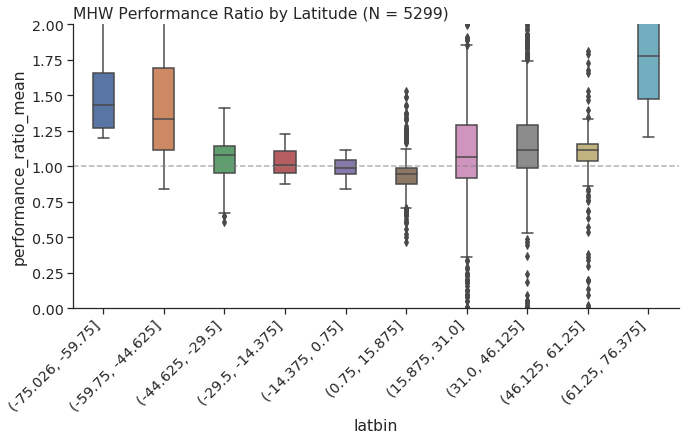

In [27]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'performance_ratio_mean', data=a, aspect=2, width=0.35)#, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
plt.ylim([-0, 2])


### **Plot**: Mean performance ratio by latitudinal bins, divided by MHW start date


<Figure size 1200x800 with 0 Axes>

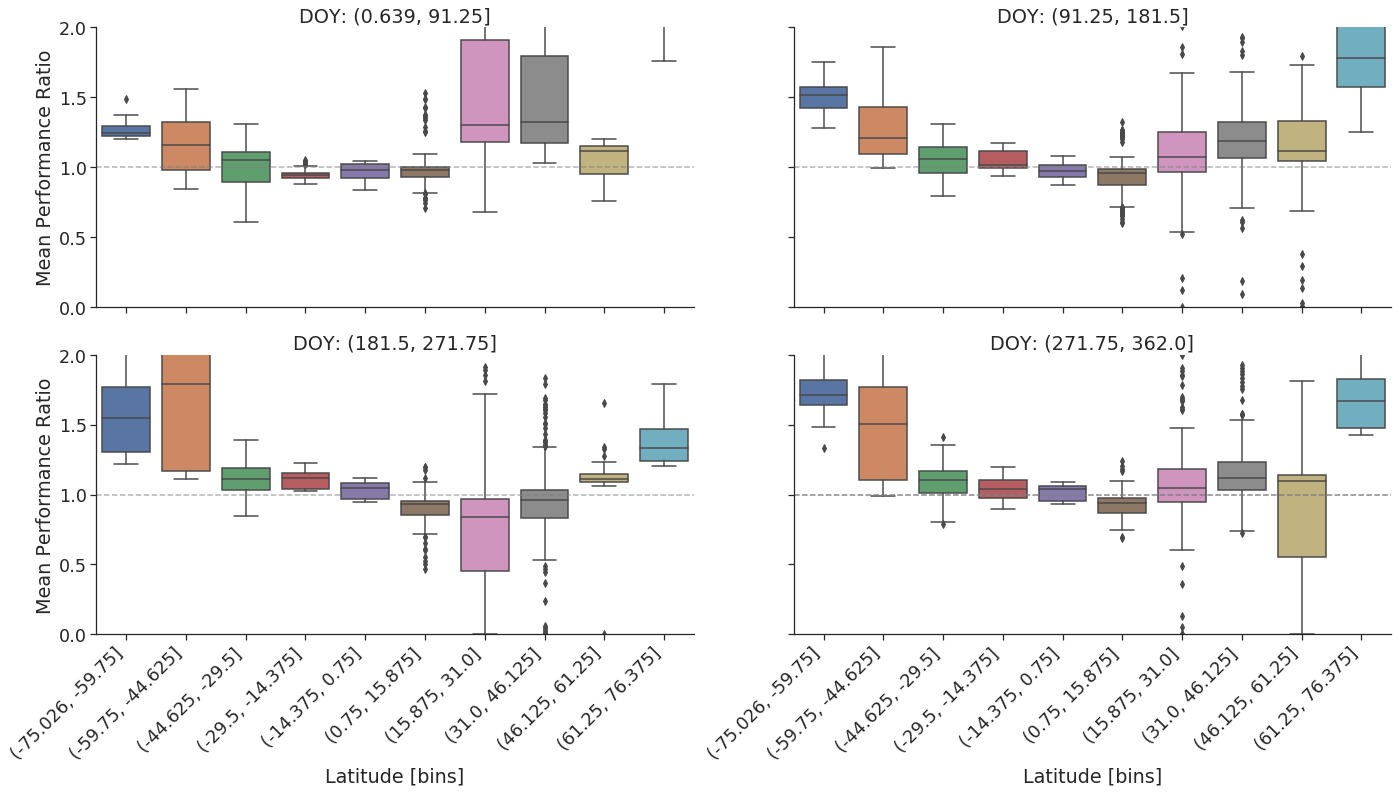

In [28]:
figure = plt.figure(dpi=200)
sns.set(font_scale=1.6, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', col='doy_bins', col_wrap = 2, y = 'performance_ratio_mean', data=a, aspect=2, )
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
# plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
list(map(lambda ax: (ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right'), ax.axhline(1,linestyle='--', alpha=0.6, color='gray')), fg.axes));
fg.set(ylim=[0, 2])
fg.set_ylabels('Mean Performance Ratio')
fg.set_xlabels("Latitude [bins]")
fg.set_titles(template='DOY: {col_name}')


### **Plot**: MHW Mean relative performance detriment by latitude

Relative detriment for an isolate $i$ is computed with reference to maximum possible performance for a given isolate, e.g. $$\textrm{R_Det}_{i}(T) = \frac{\textrm{Perf}_i(T_{\mathrm{opt} | i}) - \textrm{Perf}_i(T)}{\textrm{Perf}_i(T_{\mathrm{opt} | i})}$$

Text(0.0, 1, 'MHW Mean Relative Detriment by Latitude (N = 5299)')

<Figure size 600x400 with 0 Axes>

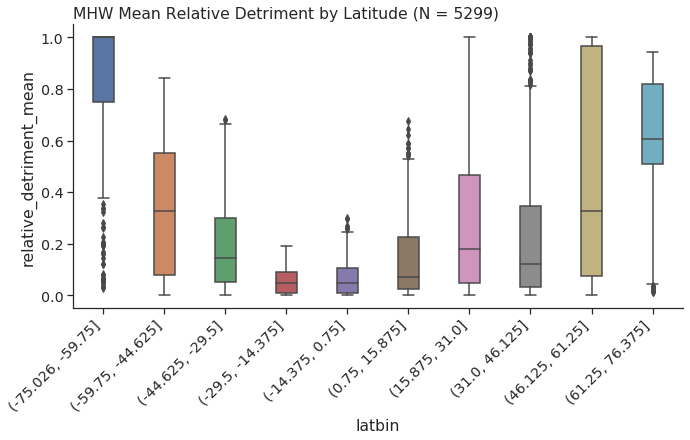

In [73]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'relative_detriment_mean', data=a, aspect=2, width=0.35)
plt.xticks(rotation=45, ha='right')
# plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Mean Relative Detriment by Latitude (N = {len(a)})", loc='left')
# plt.ylim([-1, 2])

Text(0.0, 1, 'MHW Mean Relative Detriment by Latitude (N = 5299)')

<Figure size 600x400 with 0 Axes>

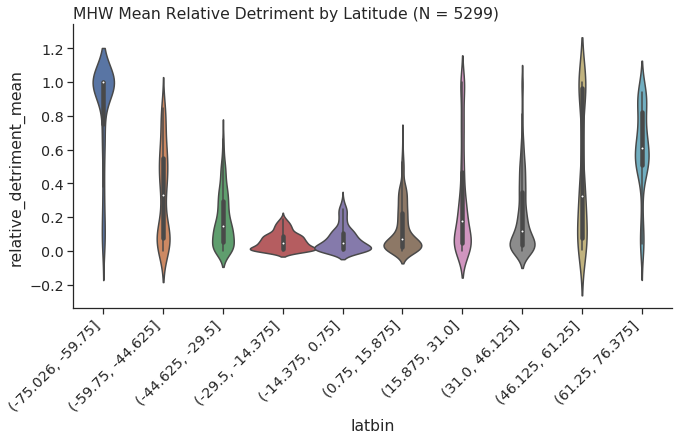

In [34]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='violin', x = 'latbin', y = 'relative_detriment_mean', data=a, aspect=2, width=1.1, dodge=True) 
plt.xticks(rotation=45, ha='right')
# plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Mean Relative Detriment by Latitude (N = {len(a)})", loc='left')
# plt.ylim([-1, 2])

In [41]:
ax

## How does this compare to modeled relationships?

Since we have these empirically-derived examples to ground the relationships between environment and performance, it would be nice to take our latitudinally-generalized reaction norm model and apply it to the same environmental record for each of our isolates above and see how the results differ. 

In [74]:
## Load Generalized Model
with open("./physiology/gtpc_modeled.pkl", 'rb') as f:
    gtpc = cloudpickle.load(f)

Compute performance for each isolate based on isolate latitude using the generalied TPC function: 

In [81]:
modeled_performances = {}
for i, (_, isolate) in tqdm.tqdm(enumerate(plankton.iterrows())):
    
    _tpc = gtpc.getLatitudinalTPC(isolate['isolation.latitude'])
    _relevant_sst = oisst.sel(
        lat=isolate['isolation.latitude'], 
        lon=isolate['isolation.longitude'],
        method='nearest', tolerance=0.25
    )
    _tmin = isolate[tmin_col]
    _tmax = isolate[tmax_col]
    _topt = isolate[topt_col]
    values = xr.apply_ufunc(
        _tpc,
        _relevant_sst.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).sst.T
    
    _relevant_mhws = isolate_mhws[isolate['isolate.code']]
    
        
    performance = xr.full_like(_relevant_sst, fill_value=0.).rename_vars({'sst' : "performance"})
    performance['performance_clim'] = xr.zeros_like(performance.performance)
    performance['topt'] = xr.zeros_like(performance.performance)
    performance['tmin'] = xr.zeros_like(performance.performance)
    performance['tmax'] = xr.zeros_like(performance.performance)
    performance.attrs = {}
    
    values_clim = xr.apply_ufunc(
        _tpc,
        _relevant_mhws.clim_seas.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).T
    
    performance['performance'] = values
    
    performance['performance_clim'] = values_clim
    
    performance['topt'] = _topt
    
    performance['tmin'] = _tmin
    
    performance['tmax'] = _tmax
    
    modeled_performances[isolate['isolate.code']] = performance.assign_coords(isolate = isolate['isolate.code'])
    

89it [00:02, 35.11it/s]


Compute (~1m, 32 cores)

In [75]:
%%time
modeled_isolate_performance = client.compute(modeled_performances, sync=True, optimize_graph=True)

NameError: name 'modeled_performances' is not defined

Merge for analysis: 

In [74]:
# isolate_merged_performance = [xr.merge([isolate_mhws[ic], isolate_performance[ic]]) for ic in plankton['isolate.code']]
isolate_modeled_performance = [xr.merge([isolate_mhws[ic], modeled_isolate_performance[ic]]) for ic in plankton['isolate.code']]

NameError: name 'modeled_isolate_performance' is not defined

In [73]:
modeled_isolates_combined = xr.concat(isolate_modeled_performance, dim='isolate')

NameError: name 'isolate_modeled_performance' is not defined

In [87]:
modeled_isolates_mhw = modeled_isolates_combined.where((modeled_isolates_combined.mhw != 0))

In [88]:
modeled_isolates_mhws_ddf = modeled_isolates_mhw.to_dask_dataframe().dropna().repartition(npartitions=20)

**In addition** to clipping negative performance values, we also clip performance values greater than 1 here: 

In [138]:
modeled_isolates_mhws_ddf.performance = modeled_isolates_mhws_ddf.performance.mask(modeled_isolates_mhws_ddf.performance < 0, 0)
modeled_isolates_mhws_ddf.performance_clim = modeled_isolates_mhws_ddf.performance_clim.mask(modeled_isolates_mhws_ddf.performance_clim < 0, 0)
modeled_isolates_mhws_ddf.performance = modeled_isolates_mhws_ddf.performance.mask(modeled_isolates_mhws_ddf.performance > 1, 1)
modeled_isolates_mhws_ddf.performance_clim = modeled_isolates_mhws_ddf.performance_clim.mask(modeled_isolates_mhws_ddf.performance_clim > 1, 1)

We need a new function for performance metrics. **We have to recompute detriments because we have changed the performance computation**

In [276]:
def compute_mhw_performance_modeled(df):
    isolate_optimal_performance = 1
    performance_detriment_mhw = isolate_optimal_performance - df.performance
    performance_detriment_clim = isolate_optimal_performance - df.performance_clim
    return pd.Series({
        'isolate' : df.isolate.min(),
        'detriment_sum' : performance_detriment_mhw.sum(),
        'relative_detriment_mean' : (performance_detriment_mhw / isolate_optimal_performance).mean(),
        'detriment_mean' : performance_detriment_mhw.mean(),
        'performance_diff_sum' : (df.performance - df.performance_clim).sum(),
        'performance_ratio_mean' : (df.performance / df.performance_clim).mean(),
        'intensity_cumulative' : df.intensity_cumulative.min(),
        'intensity_mean': df.intensity_mean.min(),
        'duration' : df.duration.min(),
        'start_doy' : df.time.dt.dayofyear.min(),
        'peak_doy' : oisst.time[int(df.index_peak.min())].dt.dayofyear.item(),
        'perf_det_ratio' : (performance_detriment_mhw / performance_detriment_clim).mean()
    })


In [250]:
oisst.time[234].dt.dayofyear.item()

113

In [141]:
%%time
mhw_events_modeled = modeled_isolates_mhws_ddf.groupby(['lat', 'lon', 'isolate', 'mhw']).apply(compute_mhw_performance_modeled).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 1.27 s, sys: 75.8 ms, total: 1.34 s
Wall time: 5.4 s


In [142]:
mhw_events_modeled = mhw_events_modeled.drop('isolate', axis=1).reset_index()

In [143]:
mhw_events_modeled['latbin'] = pd.cut(mhw_events_modeled['lat'], bins=10, )
mhw_events_modeled['doy_bins'] = pd.cut(mhw_events_modeled['start_doy'], bins=4)

### **Plot**: MHW Mean Performance Ratio by latitude [Modeled]
Same plot as above, this time with modeled data. 

<Figure size 600x400 with 0 Axes>

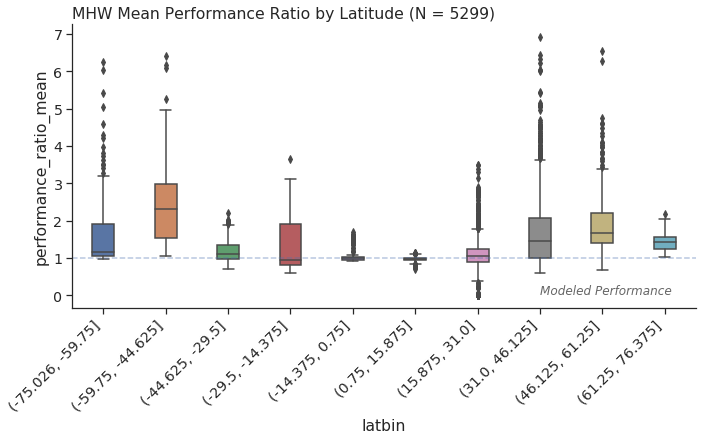

In [308]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'performance_ratio_mean', data=mhw_events_modeled, aspect=2, width=0.35)
plt.xticks(rotation=45, ha='right')
# plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Mean Performance Ratio by Latitude (N = {len(mhw_events_modeled)})", loc='left')
plt.annotate("Modeled Performance", (0.75, 0.05), xycoords='axes fraction', fontsize=12, alpha=0.7, style='italic')
plt.axhline(1.0, linestyle='--', alpha=0.4)
# plt.ylim([-0, 2])


### **Plot**: MHW Mean Performance Detriment [modeled]

Here we don't need the "relative" detriment values because the modeled reaction norm is als

Text(0.75, 0.05, 'Modeled Performance')

<Figure size 600x400 with 0 Axes>

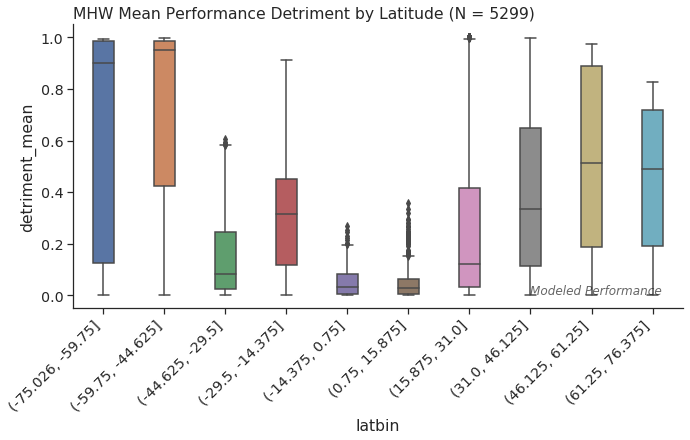

In [147]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'detriment_mean', data=mhw_events_modeled, aspect=2, width=0.35)
plt.xticks(rotation=45, ha='right')
# plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Mean Performance Detriment by Latitude (N = {len(mhw_events_modeled)})", loc='left')
plt.annotate("Modeled Performance", (0.75, 0.05), xycoords='axes fraction', fontsize=12, alpha=0.7, style='italic')
# plt.ylim([-1, 2])


## Combine Empirical + Modeled Plots

### Performance Ratio: 

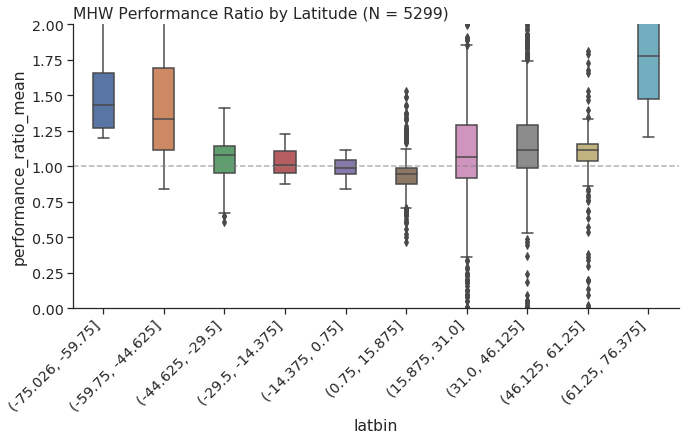

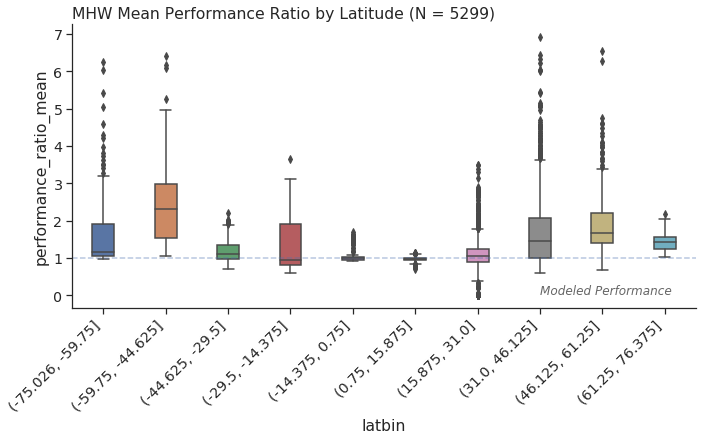

### Performance Detriment

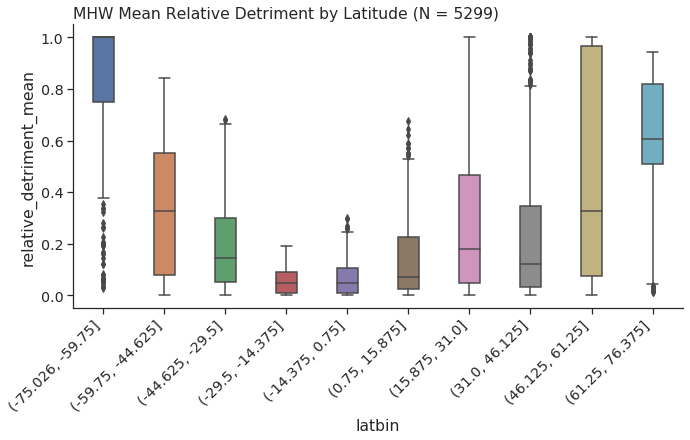

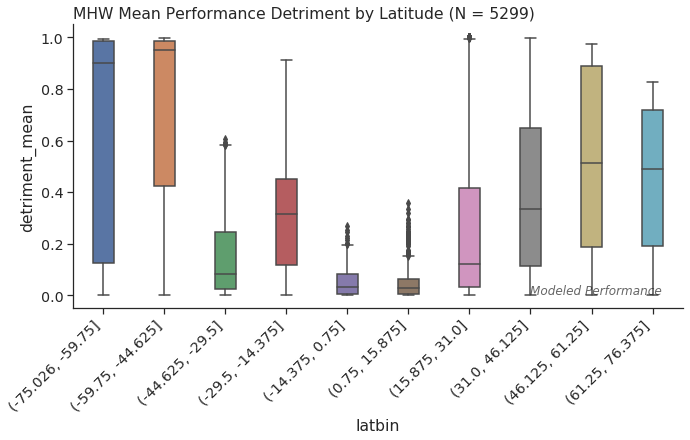

--- 
# What causes variation at each latitude in empirical data? 

The wide ranges at each latitudinal bin in the empirical data are worth figuring out. The first step is to examine these relationships with continous latitude> 

(0, 2)

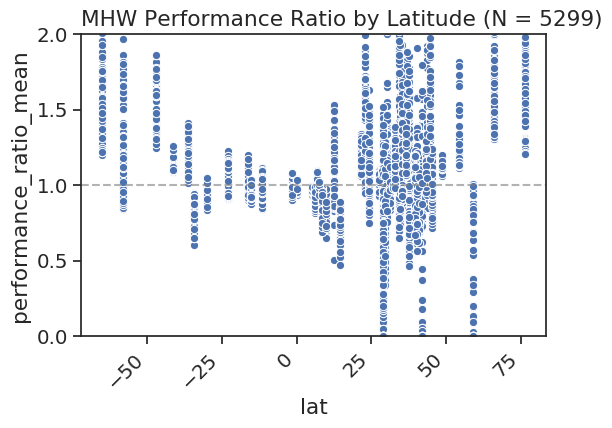

In [31]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.scatterplot(x = 'lat', y = 'performance_ratio_mean', data=a, units='isolate', estimator=np.mean, )
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
plt.ylim([-0, 2])


This is confusing. I'll generalize based on isolate. 

In [32]:
mhw_isolate_means = a.groupby('isolate').mean()
mhw_isolate_std = a.groupby('isolate').std(1)

In [33]:
mhw_isolate_combined = pd.merge(mhw_isolate_means, mhw_isolate_std, left_index=True, right_index=True, suffixes=("_mean", "_std"))

In [34]:
colors = sns.color_palette('hls', n_colors=len(mhw_isolate_means))

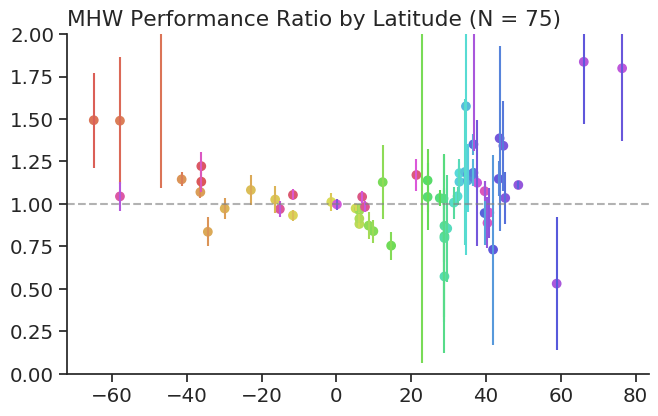

In [71]:
fig, ax = plt.subplots(figsize=(7.5,4.5), dpi=100)
sns.set(font_scale=1.3, style='ticks')
ax.scatter(x = mhw_isolate_means.lat, y = mhw_isolate_means.performance_ratio_mean, color=colors)
ax.errorbar(fmt='none', x = mhw_isolate_means.lat, y = mhw_isolate_means.performance_ratio_mean, yerr = mhw_isolate_std.performance_ratio_mean, ecolor=colors)
# ax.set_xticks(ha='right')
ax.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
ax.set_title(f"MHW Performance Ratio by Latitude (N = {len(mhw_isolate_means)})", loc='left')
ax.set_ylim([-0, 2])
sns.despine()

## Remove seasonality

We'll shift the day of year for these species by 180 to convert southern hemisphere winter into northern hemisphere winter (e.g. such that a DOY == 300 is in "winter" regardless of latitude. 

In [36]:
a.loc[a.lat.between(-90, 0), 'peak_doy'] = (a.loc[a.lat.between(-90, 0), 'peak_doy'] - 180) % 365

In [37]:
a['peak_doy_bin'] = pd.cut(a.peak_doy, bins=4)

In [38]:
mhw_isolates_season_groups = a.groupby(['isolate', 'peak_doy_bin'])

In [39]:
mhw_isolates_season = pd.concat(
    [
        mhw_isolates_season_groups.mean().add_suffix("_mean"),
        mhw_isolates_season_groups.std().add_suffix("_std"),
        mhw_isolates_season_groups.count().iloc[:, 0].rename("value_count")
    ], 
    axis=1
)

In [40]:
mhw_isolates_season = mhw_isolates_season.reset_index()

In [97]:
mhw_isolates_season

,isolate,peak_doy_bin,lat_mean,lon_mean,mhw_mean,detriment_sum_mean,relative_detriment_mean_mean,detriment_mean_mean,performance_diff_sum_mean,performance_ratio_mean_mean,...,detriment_mean_std,performance_diff_sum_std,performance_ratio_mean_std,intensity_cumulative_std,intensity_mean_std,duration_std,start_doy_std,peak_doy_std,perf_det_ratio_std,value_count
0,1,"(-0.366, 91.5]",-74.875,164.625,49.354839,2.685837,1.000000,0.329095,0.000000,NaN,...,4.299875e-17,0.000000,NaN,0.912225,0.019704,4.450444,25.877877,25.019132,0.000000,31
1,1,"(91.5, 183.0]",-74.875,164.625,52.318182,3.395659,1.000000,0.329095,0.000000,NaN,...,5.551115e-17,0.000000,NaN,6.215834,0.391581,7.060193,29.546537,29.470544,0.000000,22
2,1,"(183.0, 274.5]",-74.875,164.625,45.142857,2.961852,1.000000,0.329095,0.000000,NaN,...,3.723801e-17,0.000000,NaN,8.182987,0.457292,5.941380,75.559185,22.305775,0.000000,21
3,1,"(274.5, 366.0]",-74.875,164.625,58.000000,2.938345,1.000000,0.329095,0.000000,NaN,...,3.851856e-17,0.000000,NaN,0.780996,0.021578,4.063647,24.360905,23.660378,0.000000,28
4,3,"(-0.366, 91.5]",-66.375,110.375,40.689655,2.023161,1.000000,0.212579,0.000000,NaN,...,3.399350e-17,0.000000,NaN,0.974708,0.012789,9.194799,25.241543,24.960363,0.000000,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,572,"(274.5, 366.0]",-36.125,174.875,38.230769,3.609852,0.328899,0.196168,1.110533,1.180840,...,7.604001e-02,1.445870,0.050788,26.963086,0.163423,20.605576,27.294218,25.840487,0.093414,13
296,573,"(-0.366, 91.5]",-36.125,174.875,17.571429,6.247720,0.450076,0.267871,1.337513,1.191759,...,2.709158e-02,1.276038,0.020037,22.691492,0.116399,20.856654,27.096828,22.253946,0.029012,7
297,573,"(91.5, 183.0]",-36.125,174.875,27.750000,2.064740,0.256258,0.152517,0.920452,1.187107,...,6.402218e-02,0.884096,0.038311,19.311737,0.232016,11.764800,73.620274,25.854807,0.120245,20
298,573,"(183.0, 274.5]",-36.125,174.875,34.095238,0.125578,0.019229,0.011444,0.438483,1.069827,...,8.143729e-03,0.429586,0.017132,18.849161,0.258232,12.225461,26.218133,26.541612,0.105675,21


Text(0.5, 1.03, 'Performance Ratio by Latitude')

<Figure size 600x400 with 0 Axes>

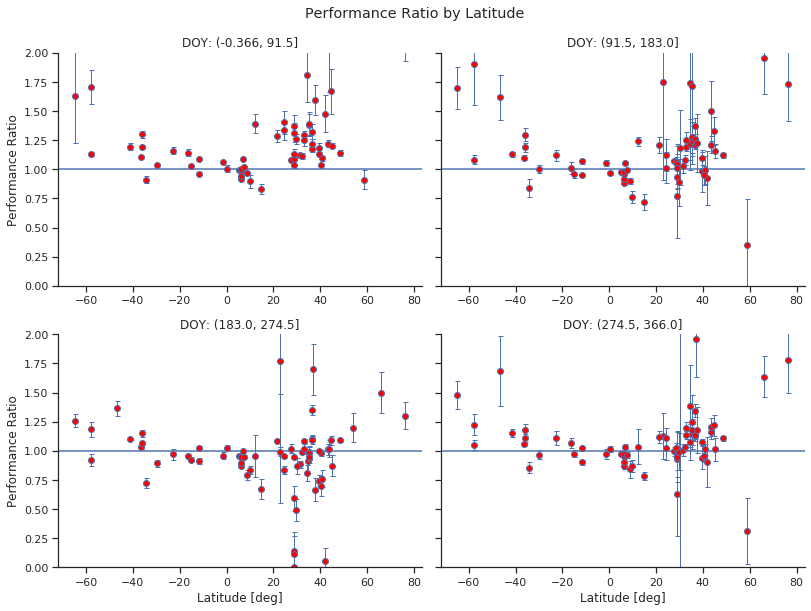

In [90]:
fig = plt.figure(dpi=100)
fg = sns.FacetGrid(
    mhw_isolates_season,
    col='peak_doy_bin', col_wrap=2,
    height=4, aspect=1.4,
    sharex=False, 
)
fg.map(
    plt.errorbar,
    'lat_mean', 'performance_ratio_mean_mean', 'performance_ratio_mean_std', 
    fmt='o', capsize=2.5, linewidth=1, mfc='red', 
)
fg.map(lambda color: plt.gca().axhline(1.0))
fg.map(lambda color: plt.gca().set_ylim([0, 2]))
fg.set_xlabels("Latitude [deg]")
fg.set_ylabels("Performance Ratio")
fg.set_titles(col_template="DOY: {col_name}")
fg.fig.suptitle('Performance Ratio by Latitude', y = 1.03, x=0.5, ha='center')


In [29]:
fig = plt.figure(dpi=100)
fg = sns.FacetGrid(
    mhw_isolates_season,
    col='peak_doy_bin', col_wrap=2,
    height=4, aspect=1.4,
    sharex=False, 
)
fg.map(
    plt.errorbar,
    'lat_mean', 'performance_ratio_mean_mean', 'performance_ratio_mean_std', 
    fmt='o', capsize=2.5, linewidth=1, mfc='red',  
)
fg.map(lambda color: plt.gca().axhline(1.0))
fg.map(lambda color: plt.gca().set_ylim([0, 2]))
fg.set_xlabels("Latitude [deg]")
fg.set_ylabels("Performance Ratio")
fg.set_titles(col_template="DOY: {col_name}")
fg.fig.suptitle('Performance Ratio by Latitude', y = 1.03, x=0.5, ha='center')
fg.set(xlim=[20, 45])

NameError: name 'mhw_isolates_season' is not defined

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

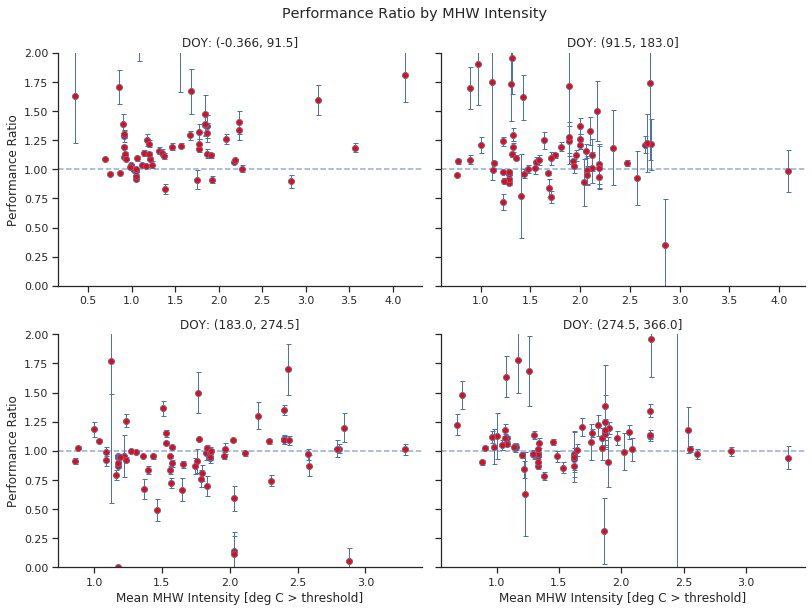

In [88]:
sns.set(style='ticks')
fig = plt.figure(dpi=100)
fg = sns.FacetGrid(
    mhw_isolates_season,
    col='peak_doy_bin', col_wrap=2,
    height=4, aspect=1.4,
    sharex=False, 
)
fg.map(
    plt.errorbar,
    'intensity_mean_mean', 'performance_ratio_mean_mean', 'performance_ratio_mean_std', 
    fmt='o', capsize=2.5, linewidth=1, mfc='red', 
)
fg.map(lambda color: plt.gca().axhline(1.0, alpha=0.6, linestyle='--'))
fg.map(lambda color: plt.gca().set_ylim([0, 2]))
fg.set_xlabels("Mean MHW Intensity [deg C > threshold]")
fg.set_ylabels("Performance Ratio")
fg.set_titles(col_template="DOY: {col_name}")
fg.fig.suptitle('Performance Ratio by MHW Intensity', y = 1.03, x=0.5, ha='center')
# fg.fig.tight_layout(rect=[0, 0, 1, 1.03])
fg.despine()
plt.savefig("_test.pdf", bbox_inches='tight')


In [137]:
def plot_sizes(x, y, sizes, err, axhline=None, **kwargs):
    sns.scatterplot(x, y, size=sizes, ax=plt.gca(), **kwargs)
    plt.gca().errorbar(x, y, yerr=err, fmt='none',capsize=2.5, linewidth=1)
    plt.gca().axhline(axhline, alpha=0.4, linestyle='--')

<Figure size 600x400 with 0 Axes>

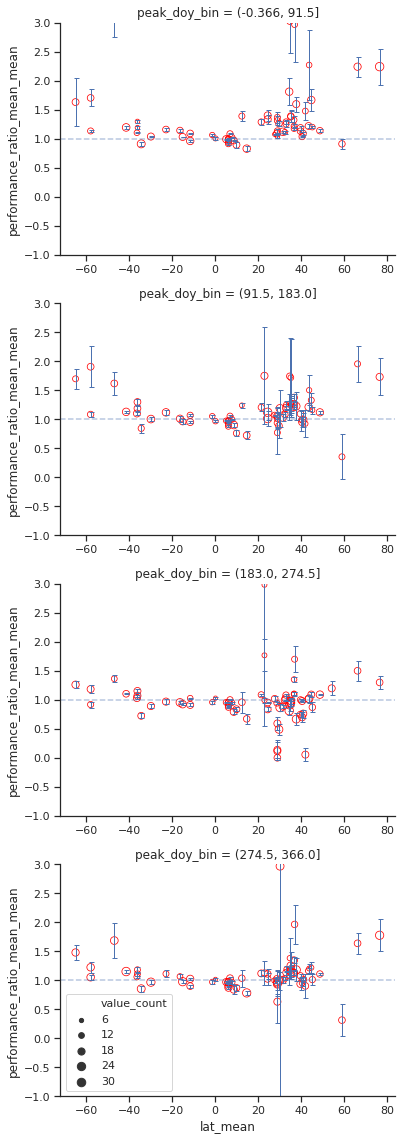

In [146]:
sns.set(style='ticks',)
fig = plt.figure(dpi=100)
fg = sns.FacetGrid(
    mhw_isolates_season,
    row='peak_doy_bin',
    height=4, aspect=1.4,
    sharex=False, 
)
fg.map(plot_sizes, 'lat_mean', 'performance_ratio_mean_mean', 'value_count', 'performance_ratio_mean_std', axhline=1.0, ec='red', fc='none')
fg.set(ylim=[-1, 3])

plt.legend()

## Comparisons to Non-MHW Times

In [103]:
isolates_combined_ddf = isolate_combined.to_dask_dataframe().dropna().repartition(npartitions=20)

In [104]:
isolates_combined_ddf.performance = isolates_combined_ddf.performance.mask(isolates_combined_ddf.performance < 0, 0)
isolates_combined_ddf.performance_clim = isolates_combined_ddf.performance_clim.mask(isolates_combined_ddf.performance_clim < 0, 0)
isolates_combined_ddf.performance = isolates_combined_ddf.performance.mask(isolates_combined_ddf.performance > 1, 1)
isolates_combined_ddf.performance_clim = isolates_combined_ddf.performance_clim.mask(isolates_combined_ddf.performance_clim > 1, 1)

In [105]:
%%time
all_events = modeled_isolates_mhws_ddf.groupby(['lat', 'lon', 'isolate', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 20.7 s, sys: 178 ms, total: 20.9 s
Wall time: 29.6 s


In [107]:
all_events = all_events.drop('isolate', axis=1).reset_index()

In [108]:
all_events['latbin'] = pd.cut(all_events['lat'], bins=10, )
all_events['doy_bins'] = pd.cut(all_events['start_doy'], bins=4)

In [111]:

non_mhw = all_events[all_events.mhw == 0]

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]


(0, 2)

<Figure size 600x400 with 0 Axes>

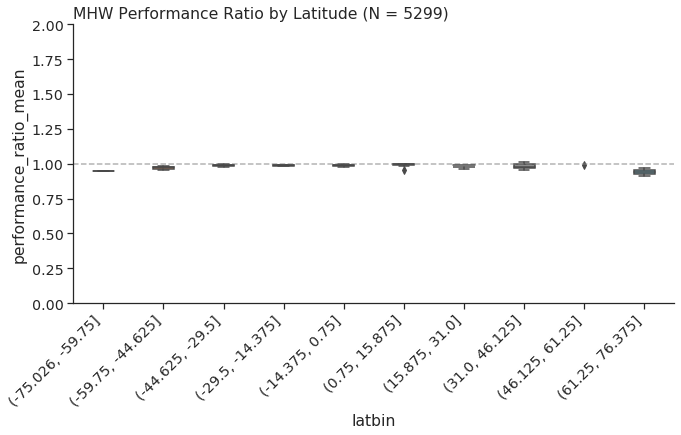

In [112]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'performance_ratio_mean', data=non_mhw, aspect=2, width=0.35)#, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
plt.ylim([-0, 2])


In [127]:
nonmhw_example = isolate_combined.where(isolate_combined.mhw == 0, drop=True).to_dask_dataframe().repartition(npartitions=20)

In [130]:
nonmhw_example['doy'] = nonmhw_example.time.dt.dayofyear

In [132]:
doy_perfdet = nonmhw_example.groupby(['lat', 'lon', 'isolate', 'doy']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [133]:
doy_perfdet = doy_perfdet.drop('isolate', axis=1).reset_index()

In [134]:
doy_perfdet['latbin'] = pd.cut(doy_perfdet['lat'], bins=10, )
doy_perfdet['doy_bins'] = pd.cut(doy_perfdet['start_doy'], bins=4)

(0, 2)

<Figure size 600x400 with 0 Axes>

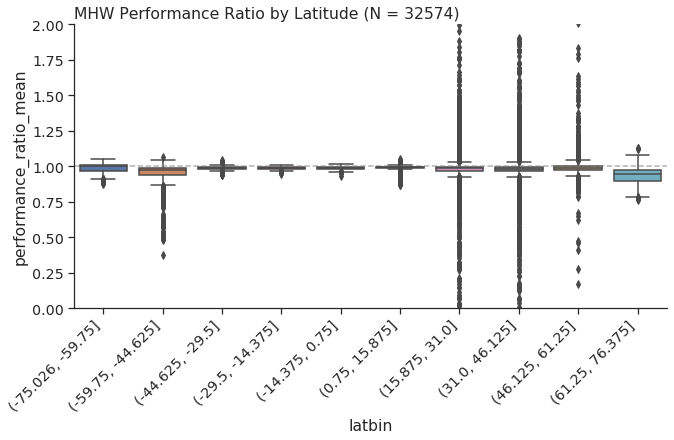

In [140]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'performance_ratio_mean', data=doy_perfdet, aspect=2,)#, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Performance Ratio by Latitude (N = {len(doy_perfdet)})", loc='left')
plt.ylim([-0, 2])


<Figure size 1200x800 with 0 Axes>

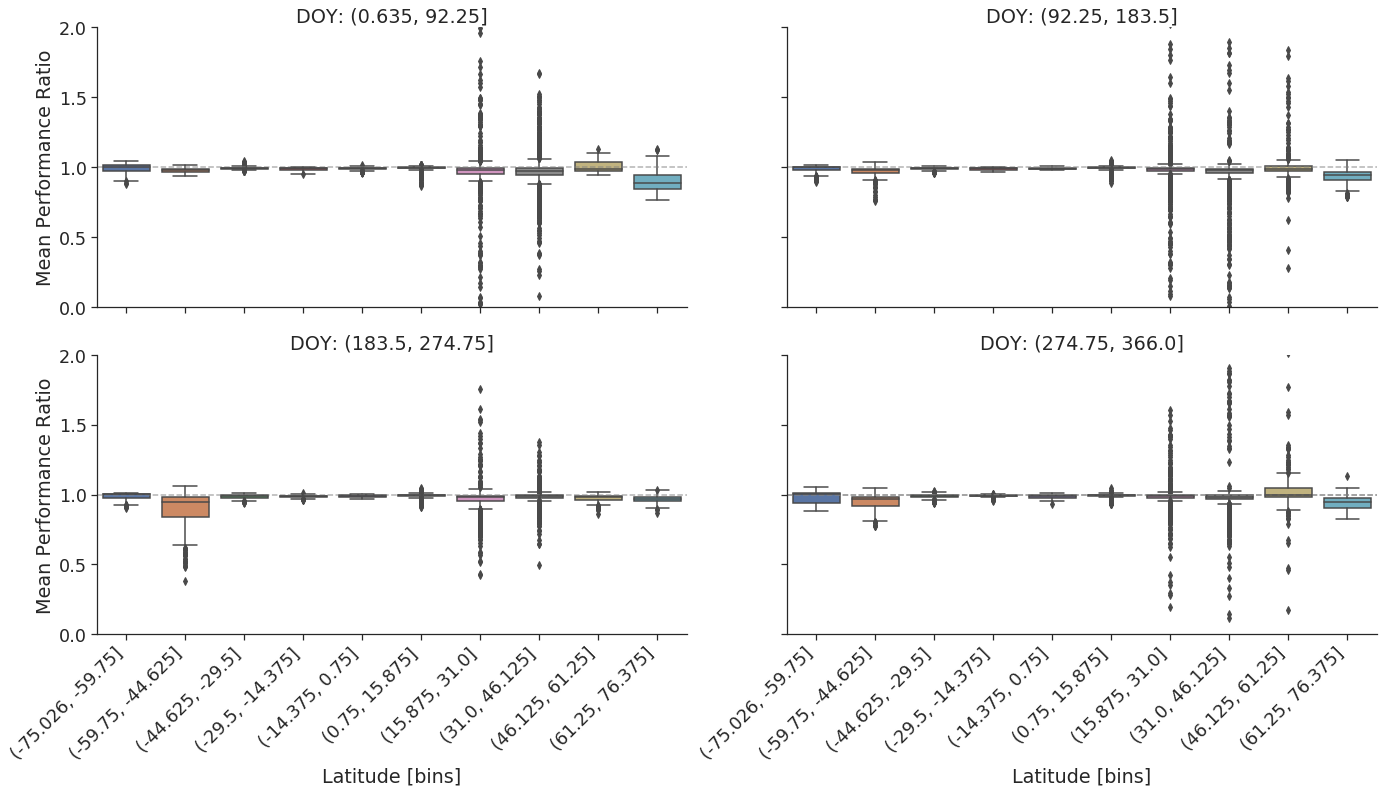

In [143]:
figure = plt.figure(dpi=200)
sns.set(font_scale=1.6, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', col='doy_bins', col_wrap = 2, y = 'performance_ratio_mean', data=doy_perfdet, aspect=2, )
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
# plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
list(map(lambda ax: (ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right'), ax.axhline(1,linestyle='--', alpha=0.6, color='gray')), fg.axes));
fg.set(ylim=[0, 2])
fg.set_ylabels('Mean Performance Ratio')
fg.set_xlabels("Latitude [bins]")
fg.set_titles(template='DOY: {col_name}')


In [145]:
doy_intervals = doy_perfdet.doy_bins.unique()
lat_intervals = doy_perfdet.latbin.unique()

In [146]:
doy_intervals

[(0.635, 92.25], (92.25, 183.5], (183.5, 274.75], (274.75, 366.0]]
Categories (4, interval[float64]): [(0.635, 92.25] < (92.25, 183.5] < (183.5, 274.75] < (274.75, 366.0]]

In [150]:
lat_intervals 

[(-75.026, -59.75], (-59.75, -44.625], (-44.625, -29.5], (-29.5, -14.375], (-14.375, 0.75], (0.75, 15.875], (15.875, 31.0], (31.0, 46.125], (46.125, 61.25], (61.25, 76.375]]
Categories (10, interval[float64]): [(-75.026, -59.75] < (-59.75, -44.625] < (-44.625, -29.5] < (-29.5, -14.375] ... (15.875, 31.0] < (31.0, 46.125] < (46.125, 61.25] < (61.25, 76.375]]

In [ ]:
example_region = 

In [174]:
doy_index = 2
lat_index = 4

no_mhw_region = doy_perfdet[
    doy_perfdet.doy_bins.isin([doy_intervals[doy_index]]) & 
    doy_perfdet.latbin.isin([lat_intervals[lat_index]])
    
]
mhw_region = a[
    a.peak_doy.between(doy_intervals[2].left, doy_intervals[doy_index].right) & 
    a.lat.between(lat_intervals[6].left, lat_intervals[lat_index].right)
]

In [175]:
mhw_region = a[
    a.peak_doy.between(doy_intervals[2].left, doy_intervals[2].right) & 
    a.lat.between(lat_intervals[6].left, lat_intervals[6].right)
]

In [182]:
len(no_mhw_region), len(mhw_region)

(364, 260)

In [177]:
from scipy.stats import ks_2samp

---

In [390]:
doy_combined = pd.concat(
    [a.rename({'peak_doy': 'doy'}, axis=1).set_index(['lat', 'lon', 'isolate', 'doy']),
    doy_perfdet.set_index(['lat', 'lon', 'isolate', 'doy'])], 
    axis=0
).reset_index()[['lat', 'latbin', 'mhw', 'doy', 'performance_ratio_mean']]
    
doy_combined = doy_combined.replace([np.inf, -np.inf], np.nan)


/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [391]:
doy_combined.loc[doy_combined.lat.between(-90, 0), 'doy'] = (doy_combined.loc[doy_combined.lat.between(-90, 0), 'doy'] - 180) % 365

In [392]:
len(doy_combined)

37873

In [393]:
doy_combined['doy_bins'] = pd.cut(doy_combined['doy'], bins=4)

In [394]:
doy_combined.mhw =  ~doy_combined.mhw.isna()

In [395]:
for col in doy_combined:
    try:
        print(col, np.isfinite(doy_combined[col]).all())
    except Exception as e: 
        e

lat True
mhw True
doy True
performance_ratio_mean False


In [396]:
doy_combined = doy_combined.dropna(subset=['performance_ratio_mean',], axis=0)

In [348]:
len(doy_combined)

32369

<Figure size 1200x800 with 0 Axes>

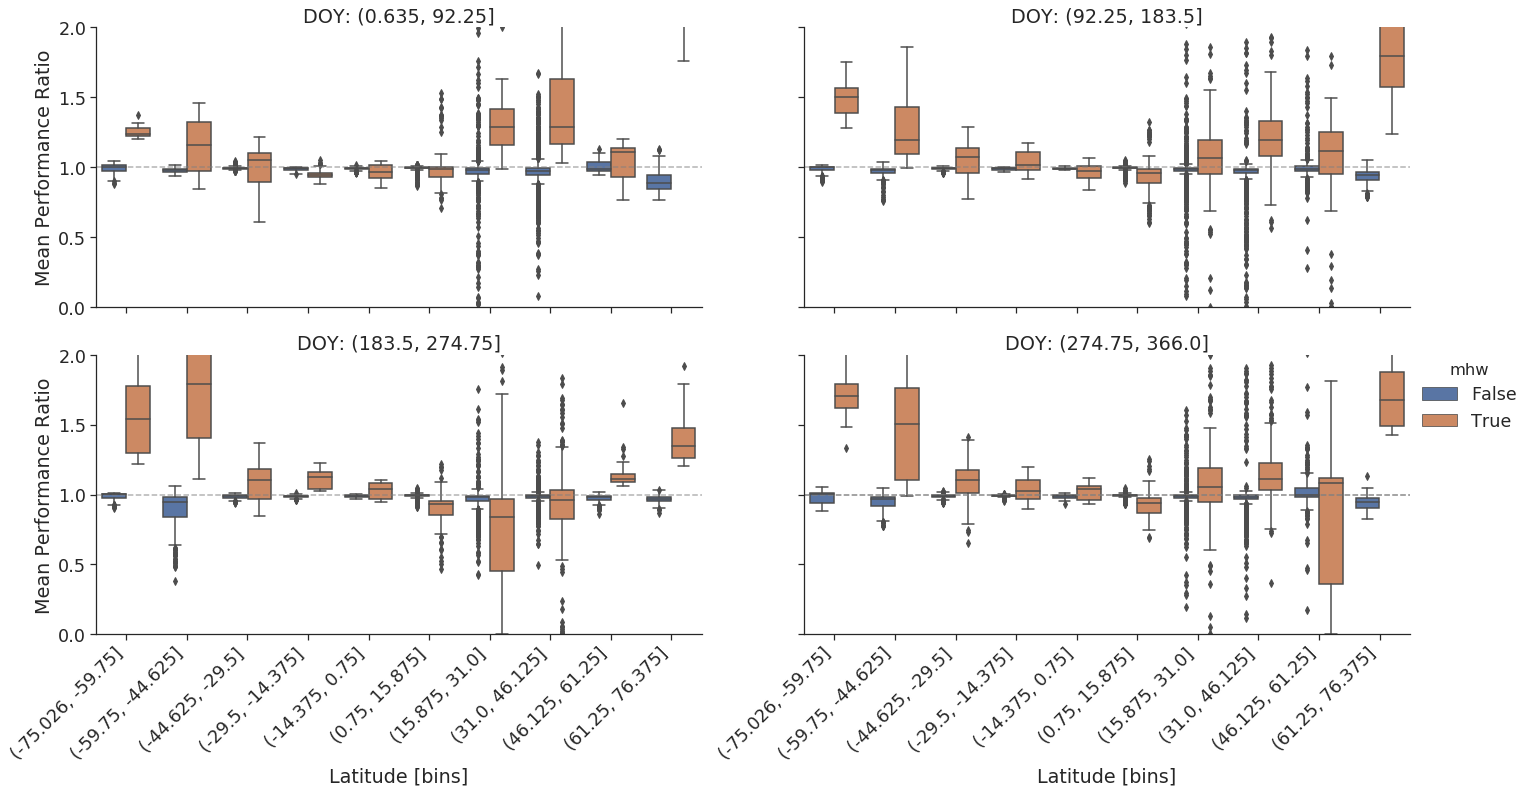

In [351]:
figure = plt.figure(dpi=200)
sns.set(font_scale=1.6, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', col='doy_bins', hue='mhw', col_wrap = 2, y = 'performance_ratio_mean', data=doy_combined, aspect=2,)
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
# plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
list(map(lambda ax: (ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right'), ax.axhline(1,linestyle='--', alpha=0.6, color='gray')), fg.axes));
fg.set(ylim=[0, 2])
fg.set_ylabels('Mean Performance Ratio')
fg.set_xlabels("Latitude [bins]")
fg.set_titles(template='DOY: {col_name}')


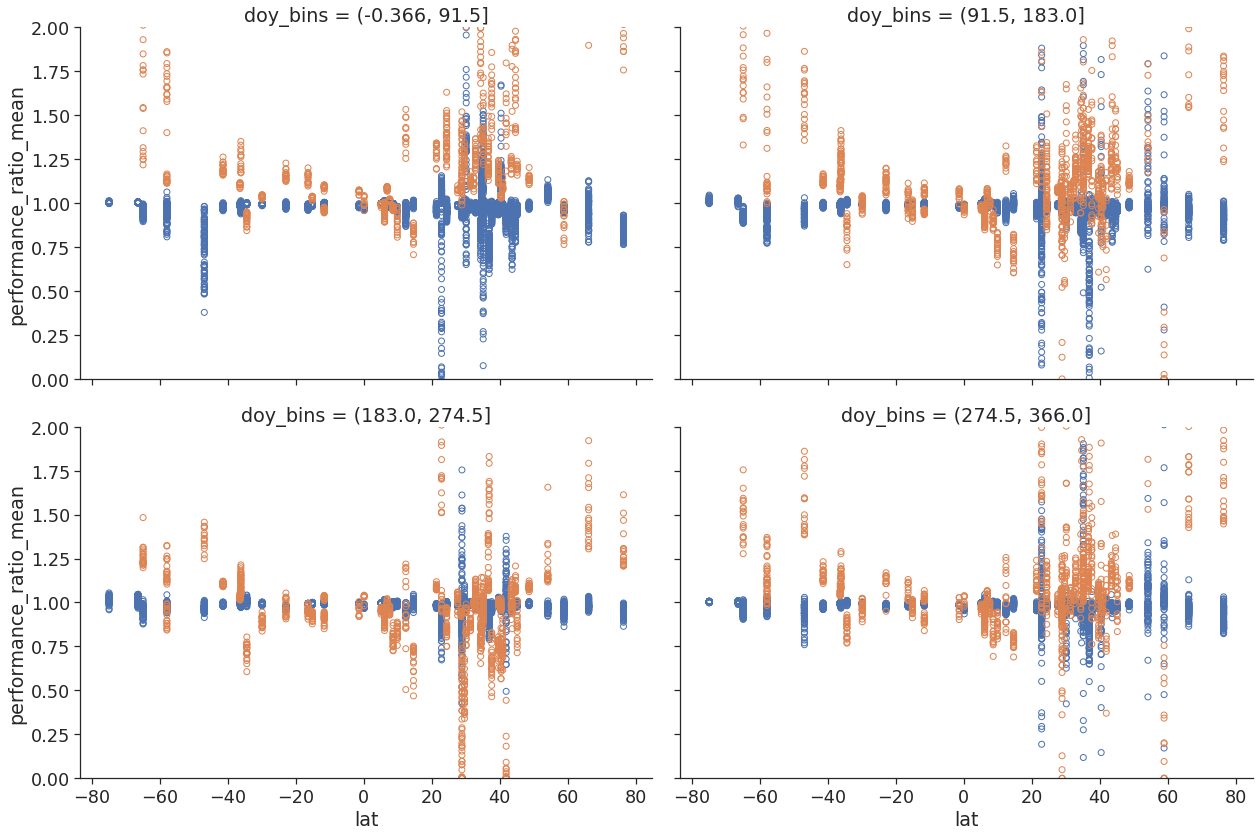

In [399]:
fg = sns.FacetGrid(
    col = 'doy_bins',
    col_wrap = 2,
    data = doy_combined, height = 6, aspect=1.5, 
    hue = 'mhw'
)

def _pltpoints(x, y, color, label=None):
    plt.gca().scatter(x, y, label=label, facecolors='none', edgecolors=color)
    
    
fg.map(_pltpoints, "lat", "performance_ratio_mean")
fg.set(ylim = [-0, 2])

(-90, 90)

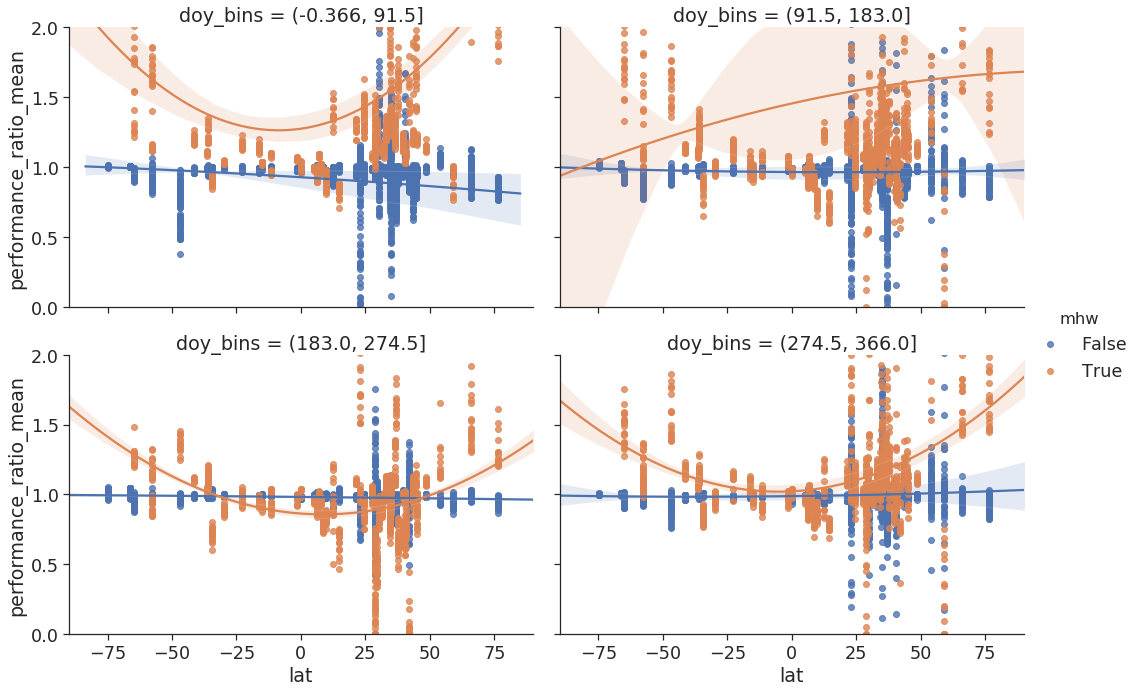

In [403]:
sns.lmplot(x = 'lat', y='performance_ratio_mean', hue = 'mhw', data=doy_combined, col_wrap=2, order = 2,aspect=1.5, col='doy_bins')
plt.ylim([0, 2])
plt.xlim([-90, 90])